In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..//src/')

ic| str_path: ('/Users/sceac10/Library/CloudStorage/OneDrive-SharedLibraries-CardiffUniversity/Energy '
               'Data - Documents/General/resources/Equipment_gain_profile_TM59.xlsx')
    sheet_name: 'Normalised'
ic| sum_profile: np.float64(1.0)


/Users/sceac10/Library/CloudStorage/OneDrive-SharedLibraries-CardiffUniversity/Energy Data - Documents/General/code/degree-days-analysis/notebooks

Users
sceac10
/sceac10/


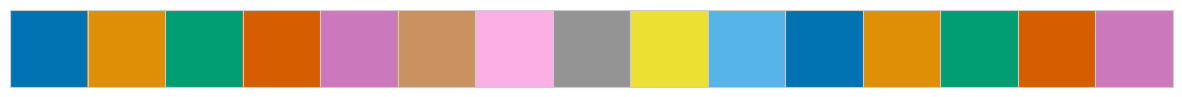

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
import sys
import random
import geopandas as gpd
from common import enums, functions, schema, viz_functions
import main
from pathlib import Path

random.seed(42)

# blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]
# sns.set_palette(sns.color_palette("Paired", 10))
# sns.set_style("white")
sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)
sns.palplot(sns.color_palette())

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

print(os.getcwd())
computer_path= ""
for x in os.getcwd().split(os.path.sep):
    print(x)
    computer_path=computer_path+x+os.path.sep
    if x == "sceac10":
        break    
    else: computer_path = os.getcwd().split(os.path.sep)[0]+os.path.sep
print(computer_path)


In [4]:
PATH_ORG = main.PATH_ORG
PATH_TABLES = PATH_ORG / r"General/communication/tables"
PATH_SAVE_FIGURES = PATH_ORG / r"General/communication/figures"
PATH_TABLES

PosixPath('/Users/sceac10/Library/CloudStorage/OneDrive-SharedLibraries-CardiffUniversity/Energy Data - Documents/General/communication/tables')

## Number of households - projection from FES 2023 - Consumer transformation - NZ.22-NZ.25: Estimated number of heating technologies and the associated emissions reduction to 2050

In [5]:
fn = "Dwellings_size.csv"
dataf = pd.read_csv(PATH_TABLES/fn, index_col=0, thousands=r',')
dataf = dataf.dropna(how='any').T
dataf = dataf/1000000
dataf.head()

Year,Number of households
2020,28.762037
2021,28.875423
2022,29.009595
2023,29.133375
2024,29.257157


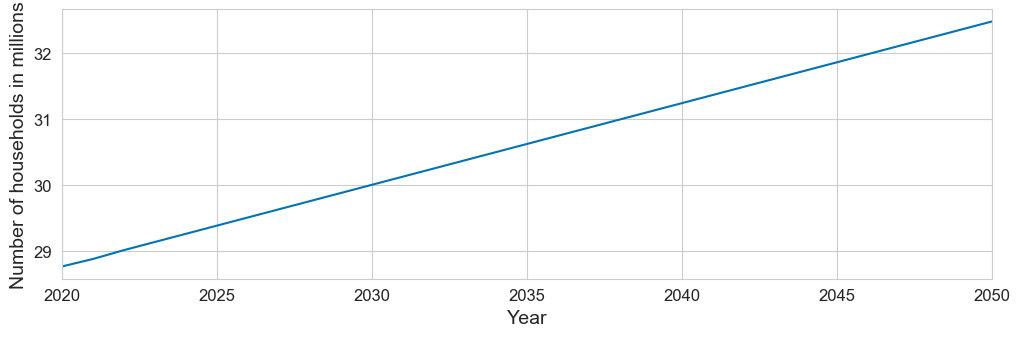

In [6]:
fig, ax = plt.subplots(figsize=figsize)
dataf.plot(ax=ax)
ax.set_ylabel('Number of households in millions')
ax.set_xlabel('Year')
ax.legend().remove()
ax.margins(0, None)

fig.savefig(PATH_SAVE_FIGURES/f"dwelling_projections.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"dwelling_projections.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

## Normalised profile for equipment gains

In [7]:
PATH_EQUIPMENT_GAINS_PROFILE = PATH_ORG /  r'General/resources/Equipment_gain_profile_TM59.xlsx'
SHEET_EQUIPMENT_GAINS_PROFILE = 'Normalised'

equipment_gains_df = pd.read_excel(PATH_EQUIPMENT_GAINS_PROFILE, sheet_name=SHEET_EQUIPMENT_GAINS_PROFILE, index_col=0)

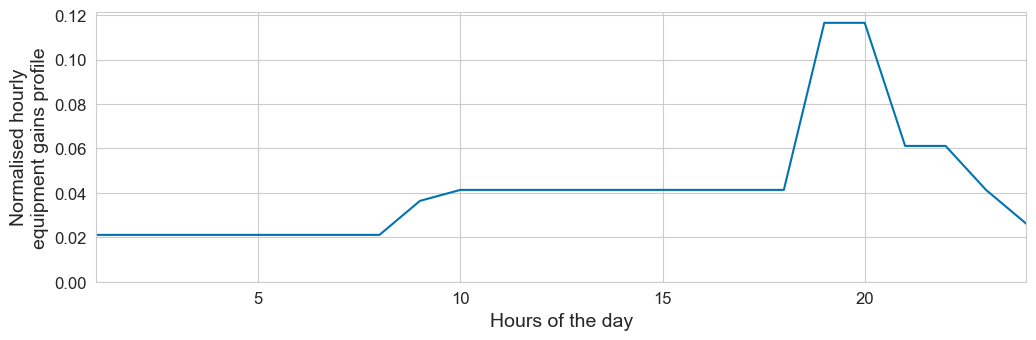

In [8]:



fig, ax = plt.subplots(figsize=figsize)
equipment_gains_df.loc['Normalised profile', :].plot(ax=ax)
ax.set_ylabel('Normalised hourly\nequipment gains profile')
ax.set_xlabel('Hours of the day')
ax.legend().remove()
ax.margins(0, None)
ax.set_ylim(0, None)

fig.savefig(PATH_SAVE_FIGURES/f"equipment_gains.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"equipment_gains.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

## Temperature profiles from CIBSE

Edinburgh_DSY2_2050High50_
Leeds_DSY2_2050High50_
Belfast_DSY2_2050High50_
Swindon_Brize_Norton_DSY2_2050High50_
Glasgow_DSY2_2050High50_
Cardiff_DSY2_2050High50_
Birmingham_DSY2_2050High50_
Southampton_DSY2_2050High50_
Manchester_DSY2_2050High50_
London_LWC_DSY2_2050High50
Newcastle_DSY2_2050High50_
Plymouth_DSY2_2050High50_


/tmp/ipykernel_83748/3190579399.py:18: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weather_data.resample('1w').agg({schema.DataSchema.SOLARRADIATION:'sum', schema.DataSchema.OAT:'mean'}).plot.scatter(
/tmp/ipykernel_83748/3190579399.py:18: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weather_data.resample('1w').agg({schema.DataSchema.SOLARRADIATION:'sum', schema.DataSchema.OAT:'mean'}).plot.scatter(
/tmp/ipykernel_83748/3190579399.py:18: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weather_data.resample('1w').agg({schema.DataSchema.SOLARRADIATION:'sum', schema.DataSchema.OAT:'mean'}).plot.scatter(
/tmp/ipykernel_83748/3190579399.py:18: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weather_data.resample('1w').agg({schema.DataSchema.SOLARRADIATION:'sum', schema.DataSchema

Norwich_DSY2_2050High50_
Nottingham_DSY2_2050High50_
London_LHR_DSY2_2050High50
London_GTW_DSY2_2050High50


/tmp/ipykernel_83748/3190579399.py:18: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weather_data.resample('1w').agg({schema.DataSchema.SOLARRADIATION:'sum', schema.DataSchema.OAT:'mean'}).plot.scatter(
/tmp/ipykernel_83748/3190579399.py:18: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weather_data.resample('1w').agg({schema.DataSchema.SOLARRADIATION:'sum', schema.DataSchema.OAT:'mean'}).plot.scatter(


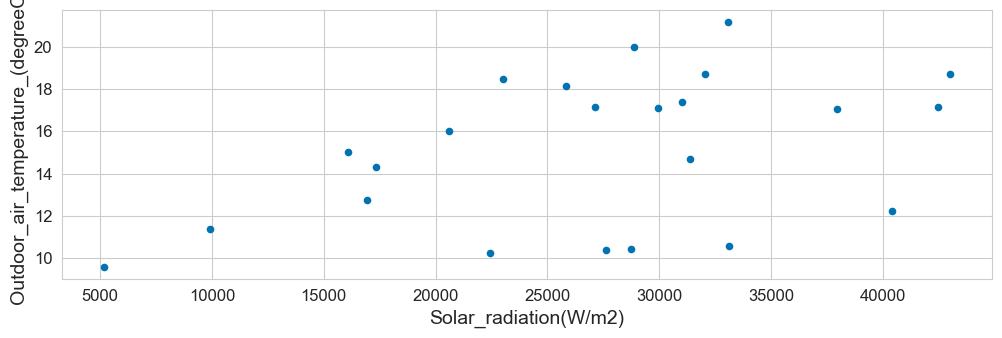

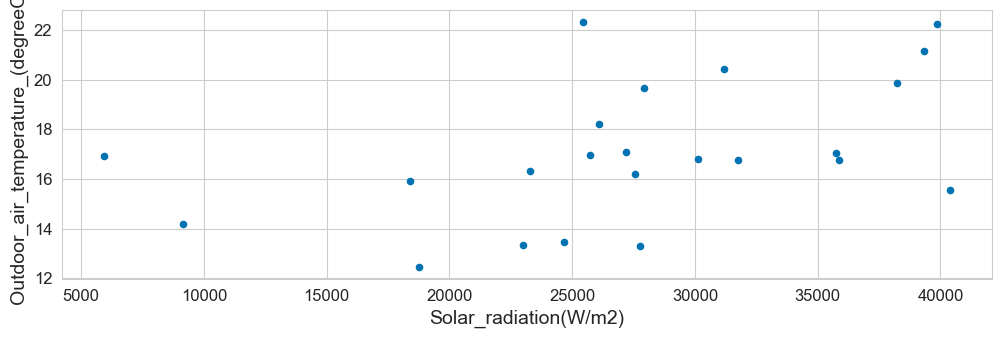

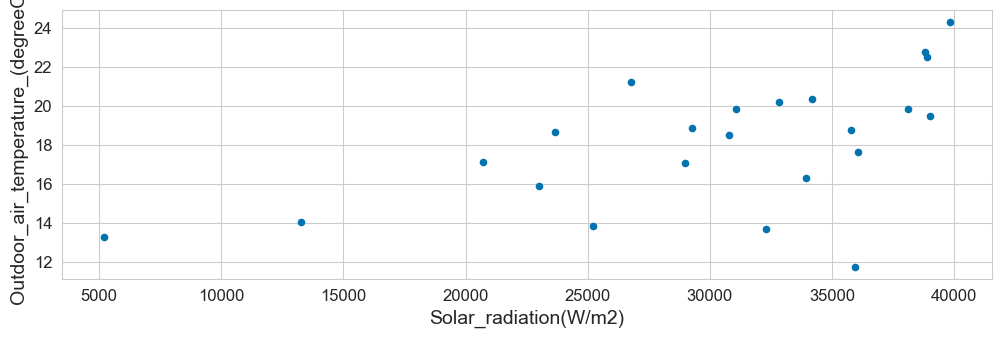

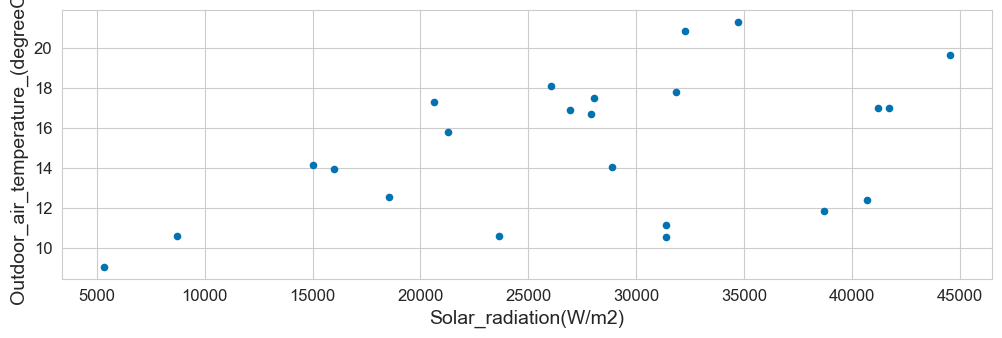

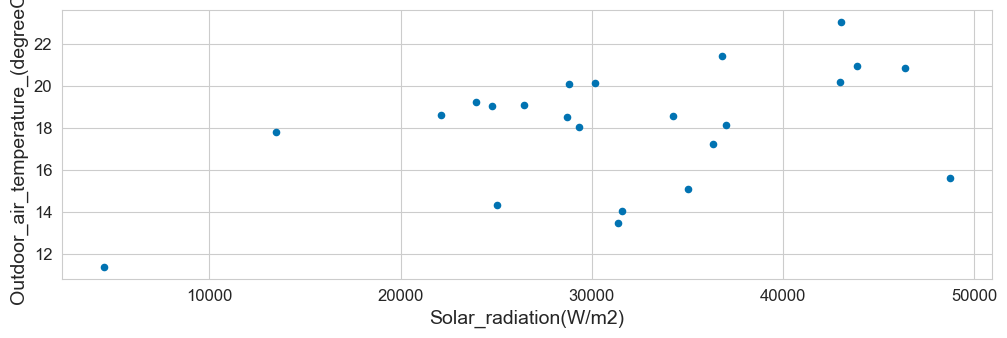

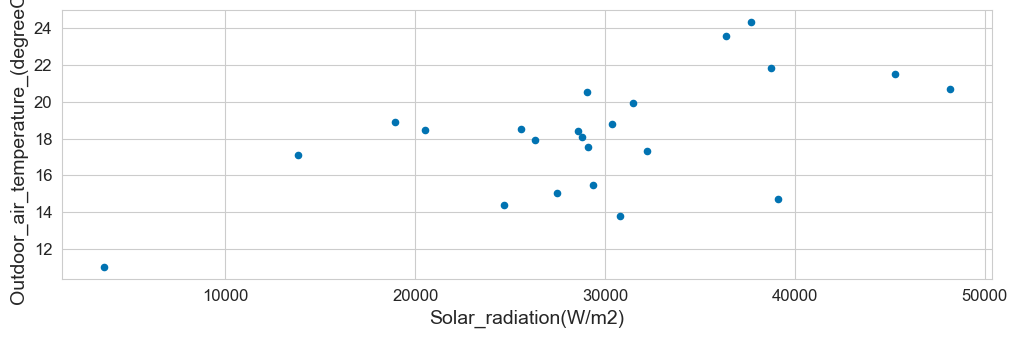

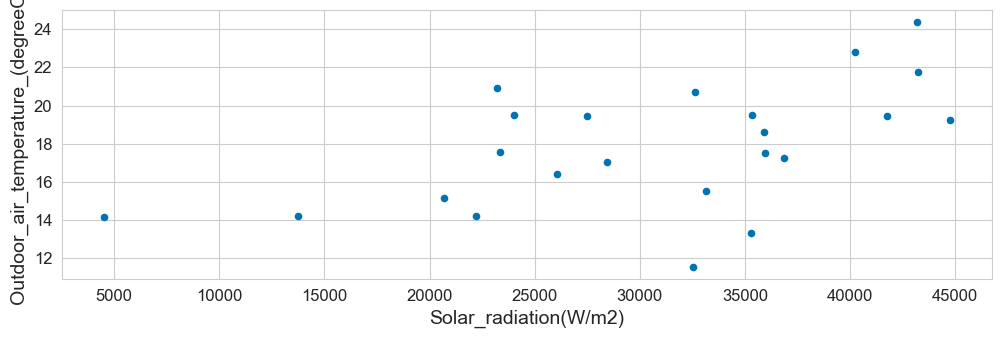

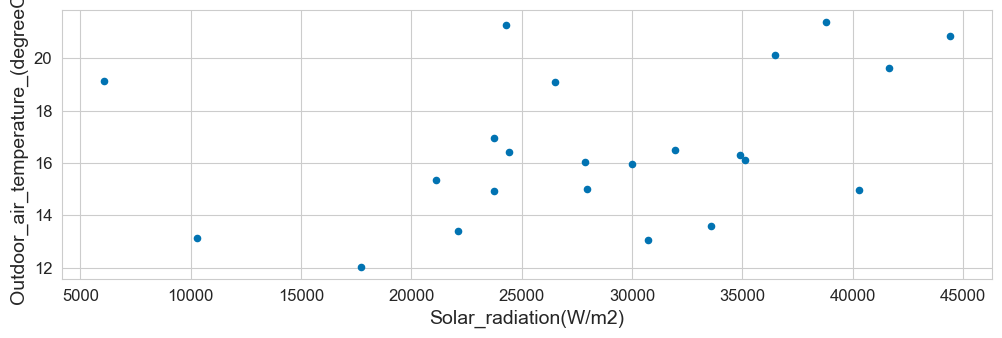

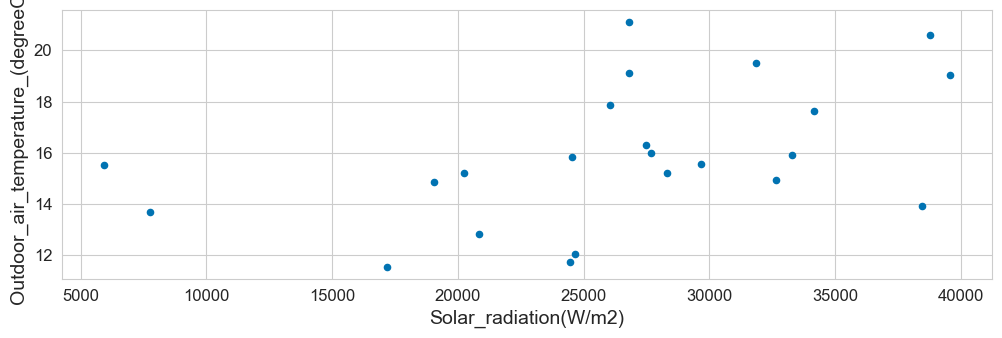

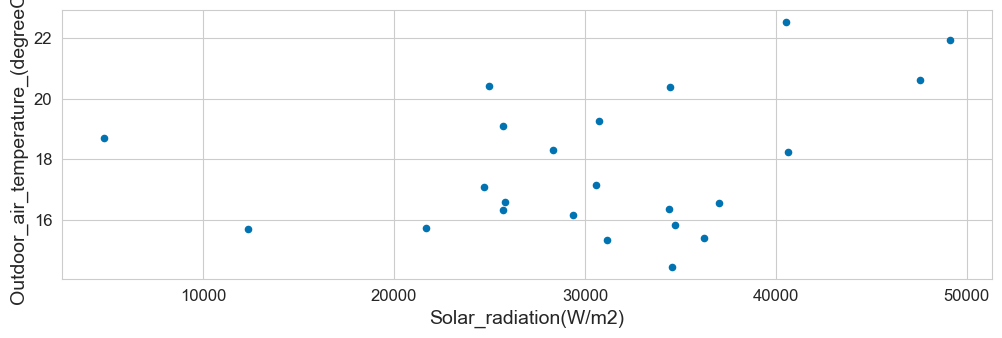

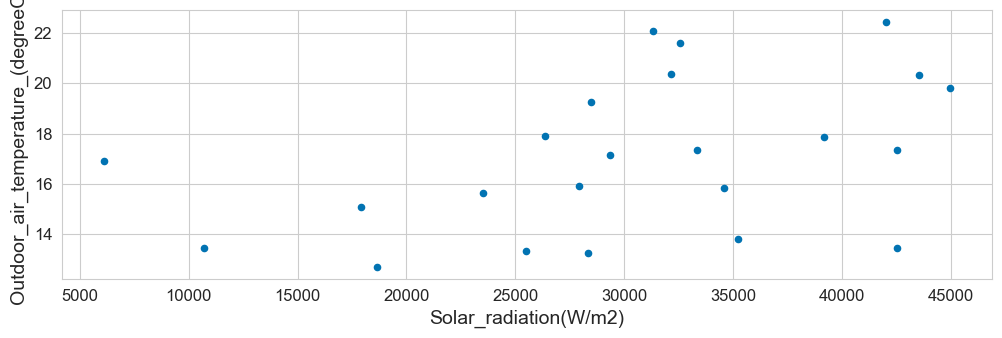

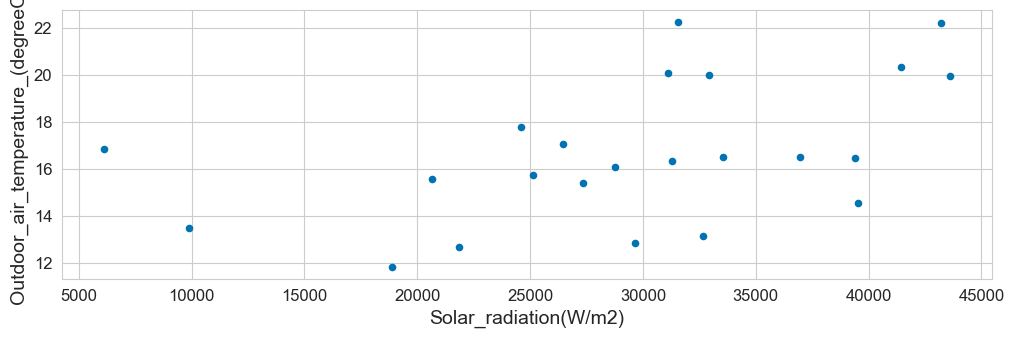

In [9]:
column_names = [
  'Year', 'Month', 'Day', 'Hour', 'PWC', 'Cloud', 'DBT', 'WBT', 'RH', 'Press', 'WD', 'WS', 'GSR', 'DSR', 'Alt', 'Dec', 'Cloud1', 'DBT1', 'WBT1', 'Press1', 'WD1', 'WS1'
]
pathlist = Path(main.PATH_CIBSE_DATA).rglob('*_DSY2_2050High50*.csv')

dict_cibse_temperature: dict[str, pd.Series] = {}
for path in pathlist:
  print(path.stem)
  if ('London' not in path.stem) and ('Belfast' not in path.stem):
    fig, ax = plt.subplots(figsize=figsize)
    la_str = path.stem.split('_DSY2_2050High50')[0]
    temp_dataf = pd.read_csv(path,
                             skiprows=32,
                             header=None,
                             delimiter=",",
                             names=column_names)
    weather_data = functions.format_weather_data(temp_dataf)
    weather_data.resample('1w').agg({schema.DataSchema.SOLARRADIATION:'sum', schema.DataSchema.OAT:'mean'}).plot.scatter(
        x=schema.DataSchema.SOLARRADIATION, y=schema.DataSchema.OAT, ax=ax)

In [10]:
column_names = [
  'Year', 'Month', 'Day', 'Hour', 'PWC', 'Cloud', 'DBT', 'WBT', 'RH', 'Press', 'WD', 'WS', 'GSR', 'DSR', 'Alt', 'Dec', 'Cloud1', 'DBT1', 'WBT1', 'Press1', 'WD1', 'WS1'
]
pathlist = Path(main.PATH_CIBSE_DATA).rglob('*_DSY2_2050High50*.csv')

dict_cibse_temperature: dict[str, pd.Series] = {}
for path in pathlist:
  print(path.stem)
  if ('London' not in path.stem) and ('Belfast' not in path.stem):
    la_str = path.stem.split('_DSY2_2050High50')[0]
    temp_dataf = pd.read_csv(path, skiprows=32, header=None, delimiter=",", names=column_names, parse_dates=True)
    dict_cibse_temperature[la_str] = functions.format_weather_data(temp_dataf)[schema.DataSchema.OAT]

Edinburgh_DSY2_2050High50_
Leeds_DSY2_2050High50_
Belfast_DSY2_2050High50_
Swindon_Brize_Norton_DSY2_2050High50_
Glasgow_DSY2_2050High50_
Cardiff_DSY2_2050High50_
Birmingham_DSY2_2050High50_
Southampton_DSY2_2050High50_
Manchester_DSY2_2050High50_
London_LWC_DSY2_2050High50
Newcastle_DSY2_2050High50_
Plymouth_DSY2_2050High50_
Norwich_DSY2_2050High50_
Nottingham_DSY2_2050High50_
London_LHR_DSY2_2050High50
London_GTW_DSY2_2050High50


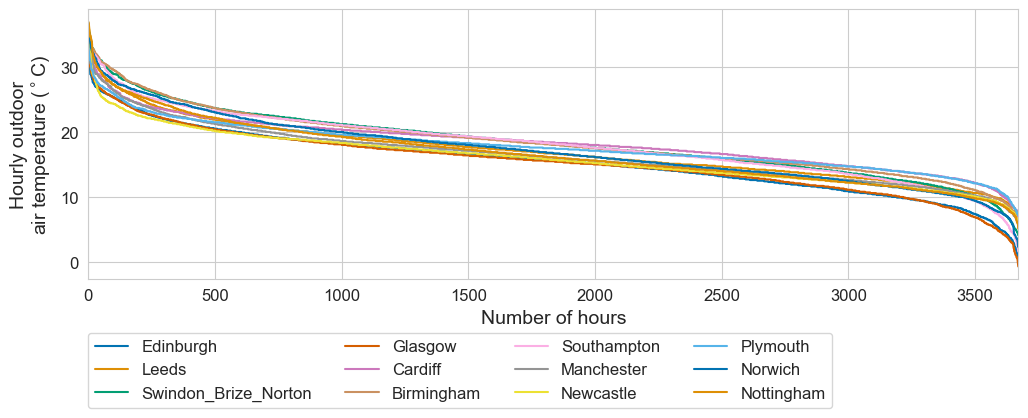

In [11]:
cibse_temp_df = pd.DataFrame(dict_cibse_temperature)
cibse_temp_df
fig, ax = plt.subplots(figsize=figsize)
for c in cibse_temp_df:
  cibse_temp_df[c].sort_values(ascending=False).reset_index(drop=True).plot(
      ax=ax)
ax.margins(0, None)
ax.set_ylabel(schema.VisualisationSchema.HOURLY_OAT)
ax.set_xlabel("Number of hours")
ax.legend(bbox_to_anchor=(0.8, -0.2), ncol=4, borderaxespad=0.)
fig.savefig(PATH_SAVE_FIGURES/f"ldc_temperature_cibse.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"ldc_temperature_cibse.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)


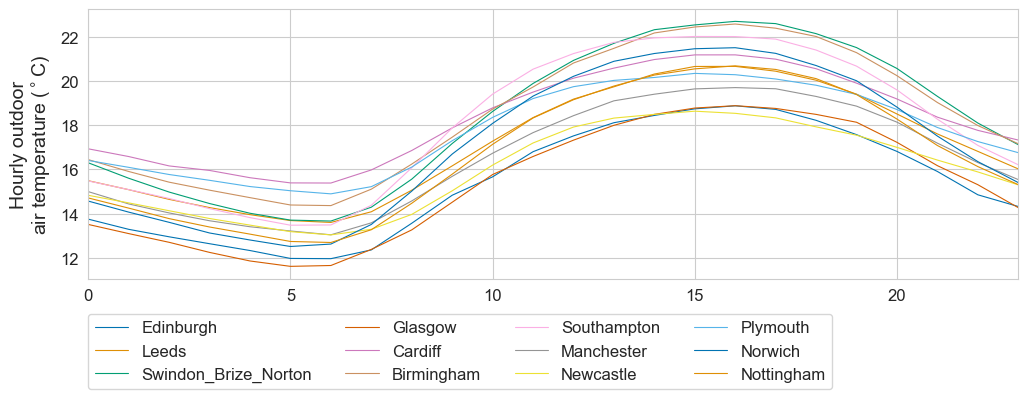

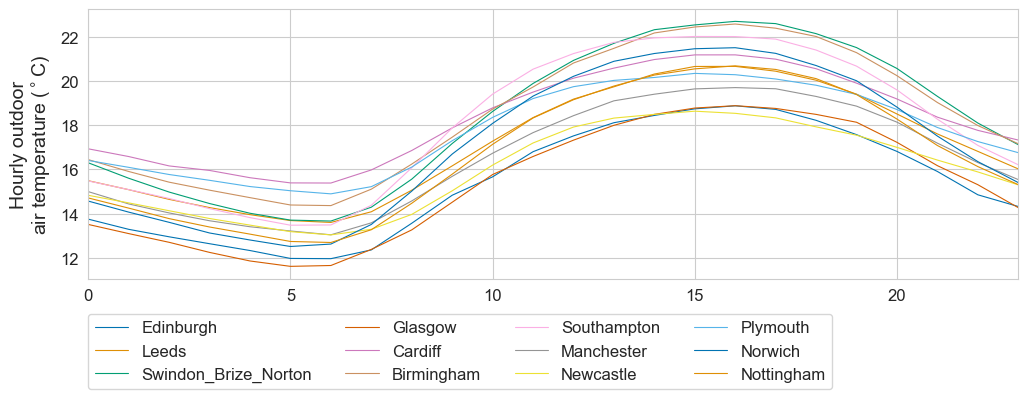

In [12]:
fig, ax = plt.subplots(figsize=figsize)
cibse_temp_df = pd.DataFrame(dict_cibse_temperature)
cibse_temp_df.groupby([cibse_temp_df.index.hour]).mean().plot(ax=ax, linewidth=0.8)
ax.set_ylabel(schema.VisualisationSchema.HOURLY_OAT)
ax.set_xlabel("")
ax.legend(bbox_to_anchor=(0.8, -0.13), ncol=4, borderaxespad=0.)
ax.margins(0, None)
fig.savefig(PATH_SAVE_FIGURES/f"average_hourly_temperature.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"average_hourly_temperature.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)
fig

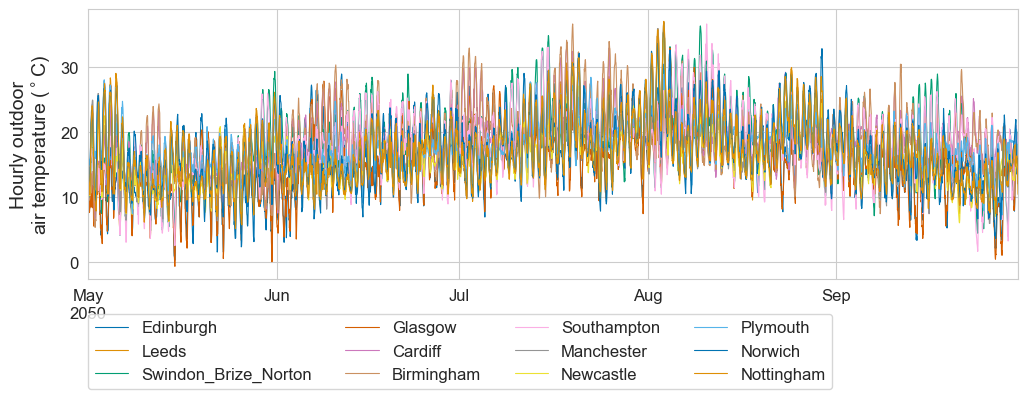

In [13]:
fig, ax = plt.subplots(figsize=figsize)
cibse_temp_df.plot(ax=ax, linewidth=0.8)
ax.set_ylabel(schema.VisualisationSchema.HOURLY_OAT)
ax.set_xlabel("")
ax.legend(bbox_to_anchor=(0.8, -0.13), ncol=4, borderaxespad=0.)
ax.margins(0, None)

fig.savefig(PATH_SAVE_FIGURES/f"cibse_temperature_profiles_DSY2_2050High50.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"cibse_temperature_profiles_DSY2_2050High50.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

## Cooling demand in GB

In [14]:
residential_data = main.import_thermal_characteristics_data(
    main.PATH_GB_DATA / 'Thermal_characteristics_afterEE.csv', 2020, 2050)
residential_data = residential_data.loc[residential_data[schema.DwellingDataSchema.THERMAL_CAPACITY_LEVEL]=="medium"]
residential_data.head()

,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC,CIBSE_city,ladcd,ladnm
Index,,,,,,,,,,,,,,,
408533,S01006506,aberdeen city,North East Scotland,detached,gas boiler,43906.250000,0.273266,115,17533.867465,175.625000,medium,-5,Edinburgh,S12000033,aberdeen city
408534,S01006506,aberdeen city,North East Scotland,detached,oil boiler,66000.000000,0.299051,14,19188.338395,264.000000,medium,-5,Edinburgh,S12000033,aberdeen city
408535,S01006506,aberdeen city,North East Scotland,detached,biomass boiler,66187.500000,0.390676,1,25067.327542,264.750000,medium,-5,Edinburgh,S12000033,aberdeen city
408536,S01006506,aberdeen city,North East Scotland,semi-detached,gas boiler,27846.153846,0.216864,68,13914.831788,111.384615,medium,-5,Edinburgh,S12000033,aberdeen city
408537,S01006506,aberdeen city,North East Scotland,semi-detached,resistance heating,22055.555556,0.113292,2,7269.253731,88.222222,medium,-5,Edinburgh,S12000033,aberdeen city


In [15]:
import icecream as ic
PATH_RESULTS = PATH_ORG / r'General/04 - Analysis/2050 high emission medium thermal capacity'
try:
  cooling_demand = pd.read_csv(PATH_RESULTS /
                                'cooling_demand_profiles_la.csv',
                                index_col=0, parse_dates=True)
  lsoa_peak = pd.read_csv(PATH_RESULTS / 'cooling_peak_results_lsoa.csv',
                          index_col=[0, 1], parse_dates=True)
except:
  lsoa_peak, cooling_demand = functions.extract_cooling_demand_profiles_and_peaks(
      PATH_RESULTS, residential_data)

/tmp/ipykernel_83748/1845257279.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lsoa_peak = pd.read_csv(PATH_RESULTS / 'cooling_peak_results_lsoa.csv',
/tmp/ipykernel_83748/1845257279.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lsoa_peak = pd.read_csv(PATH_RESULTS / 'cooling_peak_results_lsoa.csv',


In [16]:
pathlist = (Path(PATH_RESULTS) /
            'simulation').rglob('*_total_heating_outputs.csv')

index_demand_frames: dict[int, pd.Series] = {}
for temp_path in pathlist:
  ic.ic(temp_path)
  la_str = temp_path.stem.split('_total_heating_outputs')[0]
  la_code = la_str.split('_')[-1]
  temp_sim_results = pd.read_csv(temp_path, index_col=0, parse_dates=True)
  index_demand_frames[la_code] = -temp_sim_results.sum()

index_demand = pd.concat(index_demand_frames).to_frame()
index_demand.columns = [schema.VisualisationSchema.COOLINGDEMAND]

ic| temp_path: PosixPath('/Users/sceac10/Library/CloudStorage/OneDrive-SharedLibraries-CardiffUniversity/Energy Data - Documents/General/04 - Analysis/2050 high emission medium thermal capacity/simulation/north kesteven_E07000139/north kesteven_E07000139_total_heating_outputs.csv')
ic| temp_path: PosixPath('/Users/sceac10/Library/CloudStorage/OneDrive-SharedLibraries-CardiffUniversity/Energy Data - Documents/General/04 - Analysis/2050 high emission medium thermal capacity/simulation/isles of scilly_E06000053/isles of scilly_E06000053_total_heating_outputs.csv')
ic| temp_path: PosixPath('/Users/sceac10/Library/CloudStorage/OneDrive-SharedLibraries-CardiffUniversity/Energy Data - Documents/General/04 - Analysis/2050 high emission medium thermal capacity/simulation/hambleton_E07000164/hambleton_E07000164_total_heating_outputs.csv')
ic| temp_path: PosixPath('/Users/sceac10/Library/CloudStorage/OneDrive-SharedLibraries-CardiffUniversity/Energy Data - Documents/General/04 - Analysis/2050 hig

## Correlation between OAT and cooling demand

In [17]:
lookup_cibse_to_ladcd = residential_data[[schema.DwellingDataSchema.CIBSE_CITY, schema.DwellingDataSchema.LADCD]].drop_duplicates()

In [18]:
lookup_cibse_to_ladcd = lookup_cibse_to_ladcd.groupby(schema.DwellingDataSchema.CIBSE_CITY).agg({schema.DwellingDataSchema.LADCD:lambda x: list(x)})

In [19]:
daily_cooling_demand = cooling_demand.resample('1d').sum()
daily_cooling_demand.to_csv(PATH_RESULTS /
                            'daily_cooling_demand_profiles_la.csv')
daily_cooling_demand.head()

,S12000033,S12000034,E07000223,E07000026,E07000032,S12000041,S12000035,E07000224,E07000170,E07000105,...,E07000217,E08000031,E07000237,E07000229,W06000006,E07000238,E07000007,E07000239,E07000128,E06000014
Time_(h),,,,,,,,,,,,,,,,,,,,,
2050-05-01,0.0,0.0,0.000000,8.736099e+05,2.139915e+05,0.000000,0.000000,0.000000e+00,1.770008e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,9.204878e+05,3.795228e+05
2050-05-02,0.0,0.0,0.000000,1.213134e+06,5.934947e+05,0.000000,0.000000,0.000000e+00,5.058780e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,1.274549e+06,9.526064e+05
2050-05-03,0.0,0.0,15388.292608,1.690550e+06,1.469045e+06,0.000000,0.000000,3.841170e+04,1.322923e+06,1.857510e+04,...,2.869117e+04,6.131988e+04,22508.569718,3.245495e+04,1995.938058,2.739036e+04,3.507635e+04,14842.855178,1.756140e+06,2.207695e+06
2050-05-04,0.0,0.0,565437.233668,1.564761e+06,1.388388e+06,0.000000,0.000000,1.634877e+06,1.247800e+06,1.191484e+06,...,1.010392e+06,2.152247e+06,975229.092217,1.037377e+06,39548.257925,1.414060e+06,1.652635e+06,960601.904212,1.634840e+06,2.102147e+06
2050-05-05,0.0,0.0,140758.558338,6.707794e+05,2.018382e+06,4.625468,1.240847,4.210671e+05,1.825902e+06,2.995520e+05,...,2.751790e+05,5.985003e+05,274155.393264,2.654845e+05,17763.080139,3.956345e+05,3.992593e+05,253787.835075,7.103390e+05,2.975191e+06


<Axes: xlabel='index'>

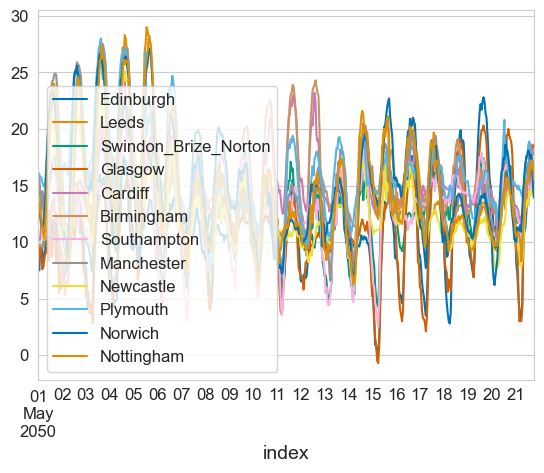

In [20]:
cibse_temp_df.head(500).plot()

In [21]:
cibse_daily_temp_df = cibse_temp_df.resample('1d').mean()

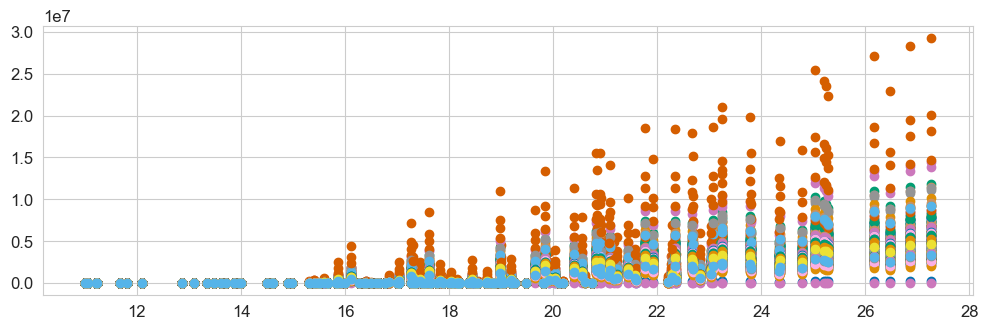

In [22]:
# The daily cooling demand against OAT is not as correlated as similar graph using heat demand as solar irradiance has a big impact on the cooling demand
# A composite outside air temperature metric would need to be used to have better correlation.
for city, list_lacd in lookup_cibse_to_ladcd.head(1).iterrows():
  fig, ax = plt.subplots(figsize=figsize)
  temp_df = daily_cooling_demand.loc[:, list_lacd.values[0]]
  for c in temp_df.columns:

    y_val = temp_df[c].values
    x_val = cibse_daily_temp_df[city]
    ax.scatter(x=x_val, y=y_val)

In [23]:
# Number of cooling degree days per city
cibse_temp_df.map(lambda x: functions.calculate_cooling_degree(x, 24)).sum()/24

Edinburgh               13.750000
Leeds                   35.412500
Swindon_Brize_Norton    61.204167
Glasgow                 14.787500
Cardiff                 25.970833
Birmingham              64.008333
Southampton             46.808333
Manchester              26.033333
Newcastle               11.900000
Plymouth                18.475000
Norwich                 47.837500
Nottingham              38.454167
dtype: float64

### Specific cooling demand by dwelling type, dwelling category and heating systems

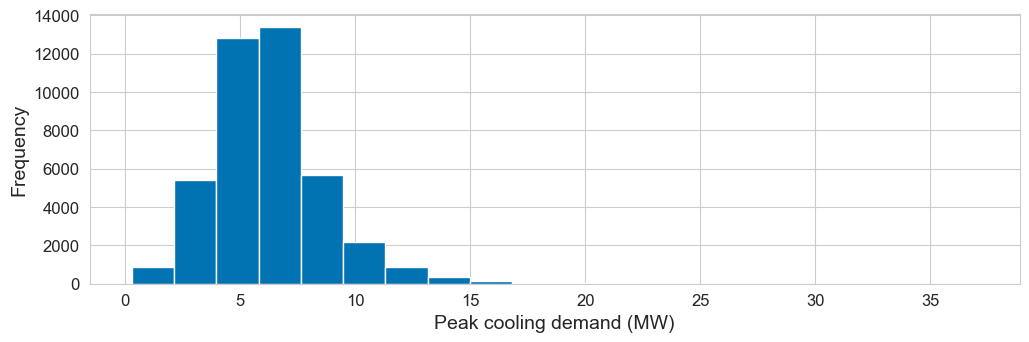

In [24]:
fig, ax = plt.subplots(figsize=figsize)
(lsoa_peak/1000).reset_index(drop=True).plot.hist(bins=20, ax=ax)
ax.set_xlabel('Peak cooling demand (MW)')
ax.legend().remove()

<Axes: ylabel='Frequency'>

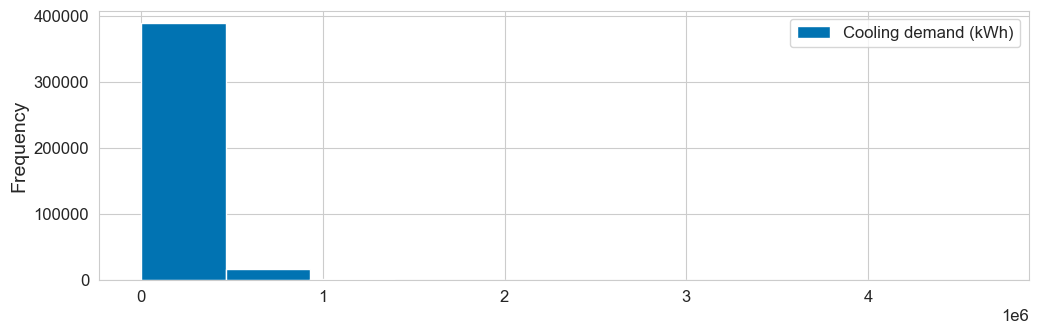

In [25]:
fig, ax = plt.subplots(figsize=figsize)
index_demand.reset_index(drop=True).plot.hist(bins=10, ax=ax)



In [26]:
index_demand.index = index_demand.index.droplevel(0)
index_demand.index= index_demand.index.astype(int)

In [27]:
all_data = pd.merge(index_demand, residential_data, left_index=True, right_index=True)
all_data[schema.ResultSchema.SPECIFICCOOLINGDEMAND_DWELLING] = all_data[schema.ResultSchema.COOLINGDEMAND]/all_data[schema.DwellingDataSchema.NB_DWELLINGS]
all_data[schema.ResultSchema.SPECIFICCOOLINGDEMAND_AREA] = all_data[
    schema.ResultSchema.SPECIFICCOOLINGDEMAND_DWELLING] / all_data[
        schema.DwellingDataSchema.FLOOR_AREA]
all_data.to_csv(PATH_RESULTS/'cooling_demand_results.csv')
all_data.head()


,Cooling demand (kWh),LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC,CIBSE_city,ladcd,ladnm,Specific cooling demand (kWh/dwelling),Specific cooling demand (kWh/m2)
714407,1003.406752,E01026179,North Kesteven,East Midlands,flat,oil boiler,25452.000000,0.224095,1,11056.126482,101.808000,medium,-3,Leeds,E07000139,north kesteven,1003.406752,9.855873
714408,43290.227692,E01026179,North Kesteven,East Midlands,detached,gas boiler,25462.817680,0.237286,44,11706.952118,101.851271,medium,-3,Leeds,E07000139,north kesteven,983.868811,9.659858
714409,2460.139608,E01026179,North Kesteven,East Midlands,detached,resistance heating,25936.500000,0.125679,2,6200.609225,103.746000,medium,-3,Leeds,E07000139,north kesteven,1230.069804,11.856552
714410,161568.357525,E01026179,North Kesteven,East Midlands,detached,oil boiler,50667.065217,0.532061,91,26250.180443,202.668261,medium,-3,Leeds,E07000139,north kesteven,1775.476456,8.760506
714411,2955.875322,E01026179,North Kesteven,East Midlands,detached,biomass boiler,29018.333333,0.412971,3,20374.661964,116.073333,medium,-3,Leeds,E07000139,north kesteven,985.291774,8.488528


In [28]:
all_data.head()
temp_pivot_data = pd.pivot_table(all_data, values='Specific cooling demand (kWh/dwelling)', columns='Dwelling forms', index='LSOA_code')
temp_pivot_data.describe()

Dwelling forms,detached,flat,semi-detached,terraced
count,41559.000000,41611.000000,41660.000000,41691.000000
mean,1784.804515,883.159144,1333.243208,1197.601820
std,712.118163,303.186062,526.218299,446.520788
min,380.484651,206.787224,354.756808,295.918084
25%,1201.527803,611.067052,898.692937,827.861619
50%,1754.027413,904.514386,1408.903934,1243.195183
75%,2280.785695,1134.948717,1696.684007,1528.765755
max,5156.276039,2054.588322,3838.368685,3293.927632


In [29]:
all_data.head()
temp_pivot_data = pd.pivot_table(all_data, values='Average floor area m2', columns='Dwelling forms', index='LSOA_code')
temp_pivot_data.describe()

Dwelling forms,detached,flat,semi-detached,terraced
count,41559.000000,41611.000000,41660.000000,41691.000000
mean,133.498433,60.126486,94.192509,84.075688
std,33.026911,10.329432,20.234025,16.612534
min,57.000000,28.440000,56.251599,47.500000
25%,110.921280,52.917647,82.363499,74.370056
50%,129.761117,58.919822,90.071266,81.450487
75%,149.469552,65.827240,100.436573,89.927216
max,339.000000,143.000000,227.059342,186.014175


In [30]:
all_data.head()
temp_pivot_data = pd.pivot_table(all_data, values='Specific cooling demand (kWh/m2)', columns='Dwelling forms', index='LSOA_code')
temp_pivot_data.describe()

Dwelling forms,detached,flat,semi-detached,terraced
count,41559.000000,41611.000000,41660.000000,41691.000000
mean,13.687722,15.016904,14.329189,14.513995
std,4.625404,4.940431,4.805938,4.923006
min,4.639544,5.365957,5.069310,5.032659
25%,9.725223,11.000528,10.493872,10.492042
50%,16.176405,17.866468,16.760917,17.171495
75%,17.999674,19.661763,18.814841,19.201164
max,21.196058,22.330925,21.730723,21.790698


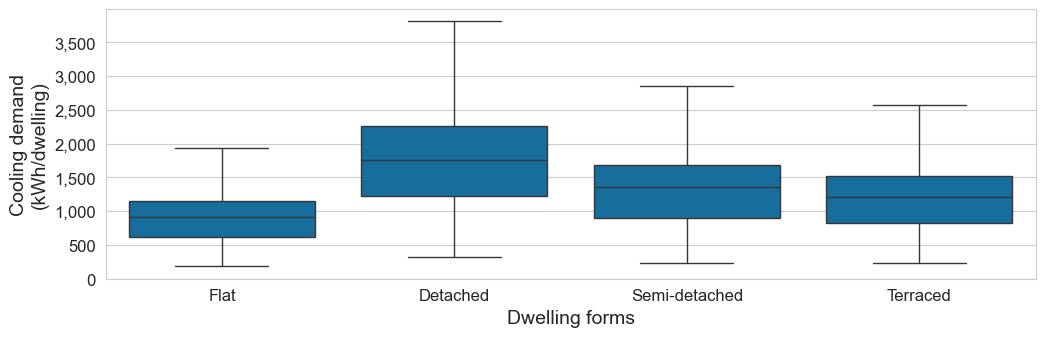

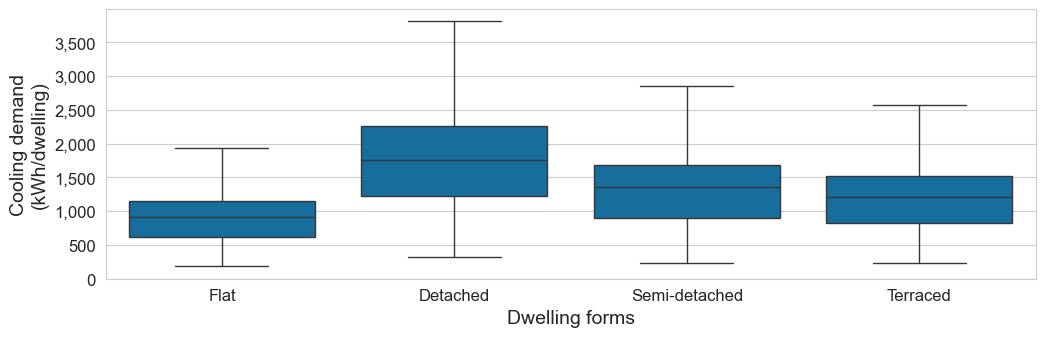

In [31]:
fig, ax = plt.subplots(figsize=figsize)
all_data[schema.DwellingDataSchema.DWELLING_FORMS] = [x.capitalize() for x in all_data[schema.DwellingDataSchema.DWELLING_FORMS]]
sns.boxplot(all_data, x=schema.DwellingDataSchema.DWELLING_FORMS, y=schema.ResultSchema.SPECIFICCOOLINGDEMAND_DWELLING, ax=ax, showfliers=False)
ax.set_ylabel(schema.VisualisationSchema.SPECIFICCOOLINGDEMAND_DWELLING)
ax.set_ylim(0, None)
ax.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: "{:,.0f}".format(x)))
fig.savefig(PATH_SAVE_FIGURES/f"dwelling_cooling_demand.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"dwelling_cooling_demand.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)
fig

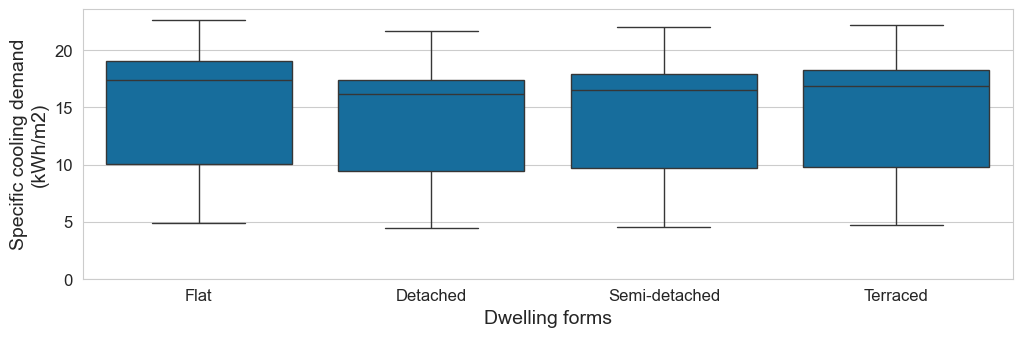

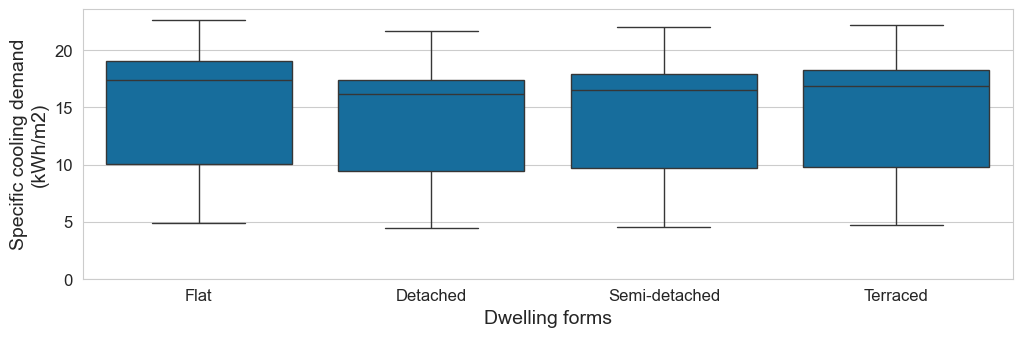

In [32]:
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(all_data, x=schema.DwellingDataSchema.DWELLING_FORMS, y=schema.ResultSchema.SPECIFICCOOLINGDEMAND_AREA, ax=ax)
ax.set_ylabel(schema.VisualisationSchema.SPECIFICCOOLINGDEMAND_AREA)
ax.set_ylim(0, None)
fig.savefig(PATH_SAVE_FIGURES/f"specific_cooling_demand.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"specific_cooling_demand.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)
fig

In [33]:
(cooling_demand.sum(axis=1)/1000000).sum()

np.float64(38234.49001810086)

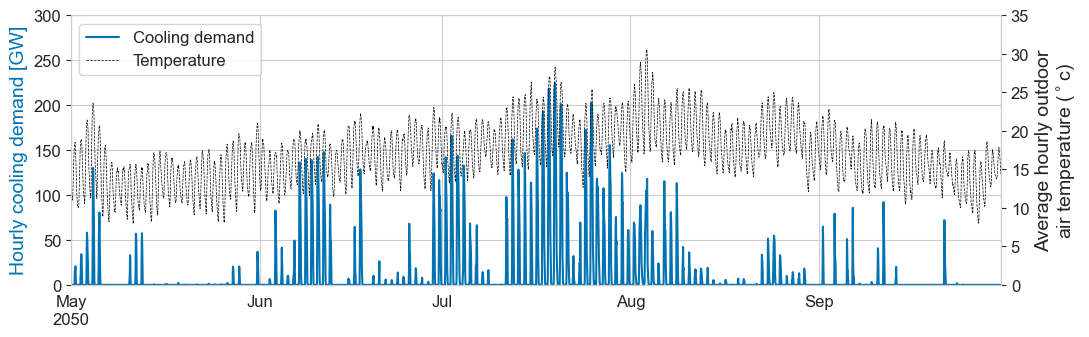

In [68]:
fig, ax = plt.subplots(figsize=figsize)

ax2 = ax.twinx()
(cooling_demand.sum(axis=1)/1000000).plot(ax=ax, label='Cooling demand')
ax.set_ylabel('Hourly cooling demand [GW]', color=sns.color_palette()[0])
ax.set_xlabel('')
ax.set_ylim(0, 300)
ax.legend()
ax.margins(0, None)

pd.DataFrame(dict_cibse_temperature).mean(axis=1).plot(ax=ax2, linewidth=0.5, color='black', linestyle='--', label='Temperature')
ax2.set_ylabel(f'Average {schema.VisualisationSchema.HOURLY_OAT.lower()}')
ax2.set_ylim(0, 35)
ax2.grid(False)

# Get handles and labels from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create a single legend
ax.legend(handles, labels, loc='upper left')

fig.savefig(PATH_SAVE_FIGURES/f"cooling_demand_GB.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"cooling_demand_GB.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)


In [35]:
### Electricity for cooling

In [36]:
scop=14/3.412 #https://www.eia.gov/todayinenergy/detail.php?id=40232
cop = scop*0.875

In [37]:
ic.ic('electricity for cooling', (cooling_demand.sum(axis=1)/1000000/scop).sum())
ic.ic('max cooling demand',(cooling_demand.sum(axis=1)/1000000/cop).max())
ic.ic('95% percentiles cooling demand',(cooling_demand.sum(axis=1)/1000000/cop).quantile(0.95))

ic| 'electricity for cooling': 'electricity for cooling'
    (cooling_demand.sum(axis=1)/1000000/scop).sum(): np.float64(9318.29142441144)
ic| 'max cooling demand': 'max cooling demand'
    (cooling_demand.sum(axis=1)/1000000/cop).max(): np.float64(62.59201223409298)
ic| '95% percentiles cooling demand': '95% percentiles cooling demand'
    (cooling_demand.sum(axis=1)/1000000/cop).quantile(0.95): np.float64(23.12285750018515)


('95% percentiles cooling demand', np.float64(23.12285750018515))

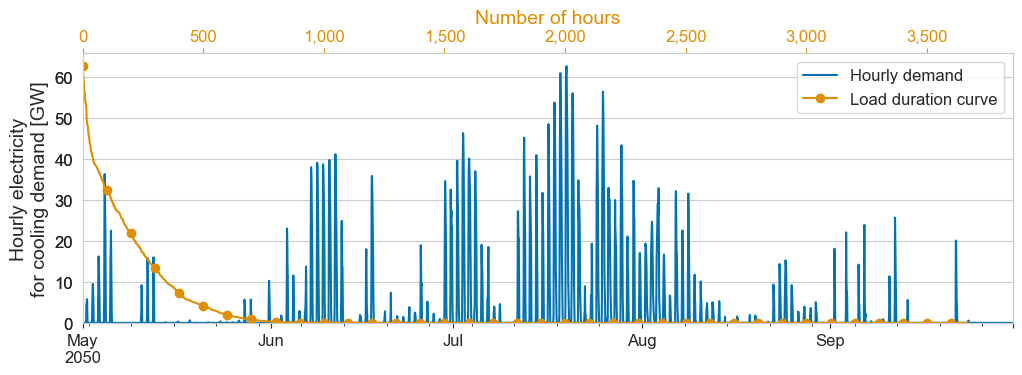

In [38]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twiny()
(cooling_demand.sum(axis=1) / 1000000 / cop).plot(ax=ax, label='Hourly demand')
ldc = cooling_demand.sum(axis=1).copy()
ldc = ldc.sort_values(ascending=False).reset_index(drop=True)/1000000/ cop
ldc.plot(ax=ax2, label='Load duration curve', marker='o', markevery=100, color=sns.color_palette()[1])
ax.set_ylabel('Hourly electricity\nfor cooling demand [GW]')
ax.set_xlabel('')

ax2.grid(False)
ax.xaxis.grid(False)
ax2.set_xlim(0, None)
ax2.set_xlabel('Number of hours')
ax2.xaxis.label.set_color(sns.color_palette()[1])
ax2.tick_params(axis='x', colors=sns.color_palette()[1])
ax2.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.margins(0, None)
ax.set_ylim(0, None)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
fig.savefig(PATH_SAVE_FIGURES/f"electricity_for_cooling_demand_GB.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"electricity_for_cooling_demand_GB.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

In [39]:
ldc[ldc>0.1]*1000

0      62592.012234
1      61216.517361
2      60887.510485
3      59968.057825
4      59468.124402
           ...     
875      105.344159
876      104.799182
877      102.930500
878      102.793051
879      100.170105
Length: 880, dtype: float64

<Axes: >

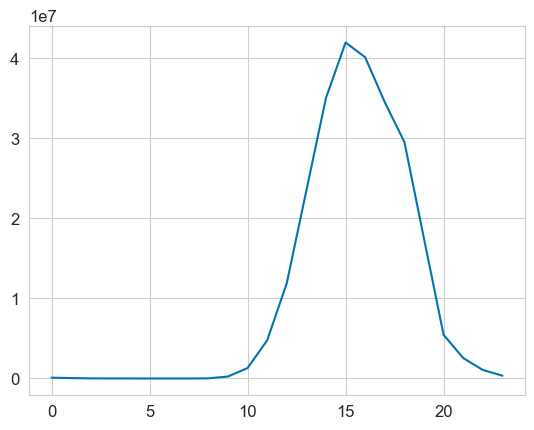

In [40]:
average_week_day = cooling_demand.sum(axis=1).groupby(
    [cooling_demand.index.hour]).mean().reset_index(drop=True)
average_week_day.plot()

<Axes: xlabel='Time_(h)'>

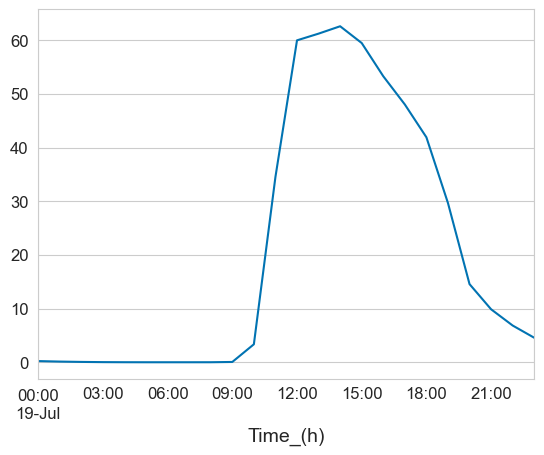

In [41]:
# Peak cooling day
from datetime import datetime
filt = cooling_demand.index.date == datetime(2050,7,19).date()
(cooling_demand.sum(axis=1) / 1000000 / cop).loc[filt].plot()

In [42]:
path_map = PATH_ORG /  r'General/resources/GIS map and data'
file = "Local_authority_UK_2019.geojson"
path_map = path_map/file

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def create_map_LA(df,
                  target,
                  path_map,
                  fig,
                  ax,
                  cmap=None,
                  percentage_scale=False, label_legend:str=''):

  map_df = gpd.read_file(path_map)
  map_df.crs = {'init': 'epsg:4326'}

  map_df = pd.merge(map_df,
                    df,
                    left_on="lad19cd",
                    right_on=schema.DwellingDataSchema.LADCD,
                    how="left")

  map_df = map_df.dropna(subset=[target])
  # create figure and axes for Matplotlib
  if percentage_scale:
    vmin = 0
    vmax = 1
  else:
    vmin = 0
    vmax = map_df[target].max()

  if cmap == None:
    cmap = 'Blues'

  ax.axis('off')
  ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

  map_df = map_df.to_crs({'init': 'epsg:3395'})  # mercator projections
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.1)

  format_axis = tkr.FuncFormatter(lambda x, p: "{:,.0f}".format(x))
  if map_df[target].max()<100:

    format_axis = tkr.FuncFormatter(lambda x, p: "{:,.1f}".format(x))

  map = map_df.plot(column=target,
              cmap=cmap,
              linewidth=0.015,
              ax=ax,
              edgecolor='black',
              vmin=vmin,
              vmax=vmax,
              legend=True,
              legend_kwds={
                      "label": label_legend,
                      "orientation": "vertical",
                      "shrink": .2,
                       "format": format_axis
                      },
              cax=cax)  #,
  plt.close()
  return map



In [44]:
# Peak cooling demand in kW
la_cooling_demand = cooling_demand.max()
la_cooling_demand = la_cooling_demand.to_frame()
la_cooling_demand = la_cooling_demand.reset_index()
la_cooling_demand.columns = [
    schema.DwellingDataSchema.LADCD, schema.DwellingDataSchema.COOLING_DEMAND]
la_cooling_demand.head()

,ladcd,Cooling demand (kWh)
0,S12000033,9.391602e+05
1,S12000034,1.308641e+06
2,E07000223,2.508046e+05
3,E07000026,4.593334e+05
4,E07000032,5.446451e+05


In [45]:
la_cooling_demand.sort_values(schema.DwellingDataSchema.COOLING_DEMAND, ascending=False).describe()/1000

,Cooling demand (kWh)
count,0.371000
mean,700.625637
std,428.247217
min,6.014953
25%,435.946683
50%,593.059954
75%,823.362680
max,3640.676891


/Users/sceac10/Library/Caches/pypoetry/virtualenvs/degree-days-analysis-g6MexP5C-py3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/sceac10/Library/Caches/pypoetry/virtualenvs/degree-days-analysis-g6MexP5C-py3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


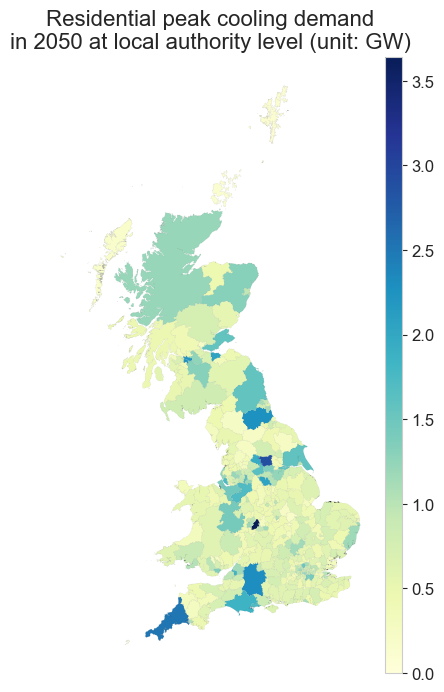

In [46]:
to_plot_df = la_cooling_demand.copy()

fig, ax = plt.subplots(figsize=(figsize_map))
target = schema.DwellingDataSchema.COOLING_DEMAND
to_plot_df[target] = to_plot_df[target]/1000000 #to GW

cmap_1 = "YlGnBu"
# create_map_LA(to_plot_df, target, path_map, fig, ax, cmap=cmap_1, label_legend='Peak cooling demand (MW)')
create_map_LA(to_plot_df, target, path_map, fig, ax, cmap=cmap_1)
ax.set_title(
    f"Residential peak cooling demand\nin 2050 at local authority level (unit: GW)")

fig.savefig(PATH_SAVE_FIGURES/f"residential_peak_cooling_demand_la_map.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"residential_peak_cooling_demand_la_map.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)
fig


In [47]:
all_data['Total Floor area'] = all_data[schema.DwellingDataSchema.NB_DWELLINGS]*all_data[schema.DwellingDataSchema.FLOOR_AREA]
la_data = all_data.groupby(schema.DwellingDataSchema.LADNM).agg({schema.DwellingDataSchema.COOLING_DEMAND:'sum',
                                                       schema.DwellingDataSchema.NB_DWELLINGS:'sum',
                                                       schema.DwellingDataSchema.FLOOR_AREA:'mean',
                                                       schema.DwellingDataSchema.HEATING_DEMAND:'sum',
                                                       'Total Floor area':'sum'})


la_data.head()

,Cooling demand (kWh),Number of dwellings,Average floor area m2,Average annual heat demand kWh,Total Floor area
ladnm,,,,,
aberdeen city,7.455338e+07,133168,101.620774,2.338380e+07,1.143219e+07
aberdeenshire,1.017068e+08,133173,107.960311,4.374446e+07,1.598449e+07
adur,4.516391e+07,29773,84.402059,2.732599e+06,2.549095e+06
allerdale,4.622803e+07,47738,107.648254,8.592840e+06,4.973585e+06
amber valley,5.474146e+07,59840,89.998740,7.367334e+06,5.610438e+06


In [48]:
la_data.sort_values(schema.DwellingDataSchema.HEATING_DEMAND, ascending=False).head(10)

,Cooling demand (kWh),Number of dwellings,Average floor area m2,Average annual heat demand kWh,Total Floor area
ladnm,,,,,
fife,1.335424e+08,199550,98.336276,4.509061e+07,1.876664e+07
highland,1.114047e+08,133170,101.942208,4.473406e+07,1.480305e+07
aberdeenshire,1.017068e+08,133173,107.960311,4.374446e+07,1.598449e+07
city of edinburgh,1.844885e+08,281653,102.078396,4.226483e+07,2.475338e+07
glasgow city,1.891122e+08,351191,93.304625,4.120045e+07,2.743365e+07
birmingham,6.797176e+08,429934,86.689080,4.091272e+07,3.788374e+07
south lanarkshire,1.018329e+08,170595,97.937723,3.750335e+07,1.605280e+07
cornwall,4.672335e+08,263122,93.917608,3.728852e+07,2.606400e+07
county durham,2.301110e+08,256969,98.895163,3.514359e+07,2.342018e+07


In [49]:
la_data.sort_values('Total Floor area', ascending=False).head(10)

,Cooling demand (kWh),Number of dwellings,Average floor area m2,Average annual heat demand kWh,Total Floor area
ladnm,,,,,
birmingham,6.797176e+08,429934,86.689080,4.091272e+07,3.788374e+07
leeds,3.083777e+08,353997,88.126937,3.476330e+07,3.076655e+07
glasgow city,1.891122e+08,351191,93.304625,4.120045e+07,2.743365e+07
cornwall,4.672335e+08,263122,93.917608,3.728852e+07,2.606400e+07
city of edinburgh,1.844885e+08,281653,102.078396,4.226483e+07,2.475338e+07
county durham,2.301110e+08,256969,98.895163,3.514359e+07,2.342018e+07
wiltshire,4.088655e+08,229628,94.884308,3.159743e+07,2.331301e+07
sheffield,2.110715e+08,247619,85.699676,2.381258e+07,2.130431e+07
bradford,1.961831e+08,214049,93.994153,2.556065e+07,2.012659e+07


In [50]:
la_data.sort_values(schema.DwellingDataSchema.COOLING_DEMAND, ascending=False).head(10)

,Cooling demand (kWh),Number of dwellings,Average floor area m2,Average annual heat demand kWh,Total Floor area
ladnm,,,,,
birmingham,6.797176e+08,429934,86.689080,4.091272e+07,3.788374e+07
cornwall,4.672335e+08,263122,93.917608,3.728852e+07,2.606400e+07
wiltshire,4.088655e+08,229628,94.884308,3.159743e+07,2.331301e+07
dorset,3.309825e+08,185289,96.044726,2.197097e+07,1.889193e+07
"bristol, city of",3.273095e+08,207927,92.260612,1.867514e+07,1.848200e+07
"bournemouth, christchurch and poole",3.121481e+08,193020,88.893288,1.498053e+07,1.767883e+07
leeds,3.083777e+08,353997,88.126937,3.476330e+07,3.076655e+07
barnet,2.680281e+08,156251,97.739228,1.458594e+07,1.527083e+07
shropshire,2.615733e+08,142242,97.650552,2.440653e+07,1.473637e+07


/Users/sceac10/Library/Caches/pypoetry/virtualenvs/degree-days-analysis-g6MexP5C-py3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/sceac10/Library/Caches/pypoetry/virtualenvs/degree-days-analysis-g6MexP5C-py3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


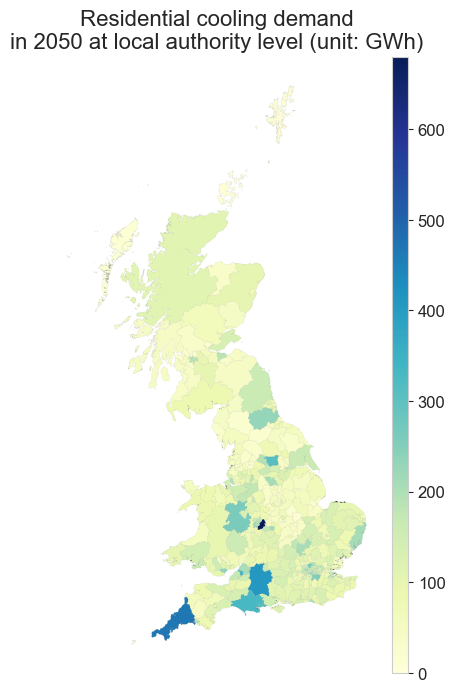

In [51]:
# Annual cooling demand GWh
la_cooling_demand = cooling_demand.sum()
la_cooling_demand = la_cooling_demand.to_frame()
la_cooling_demand = la_cooling_demand.reset_index()
la_cooling_demand.columns = [
    schema.DwellingDataSchema.LADCD, schema.DwellingDataSchema.COOLING_DEMAND]
la_cooling_demand.head()


to_plot_df = la_cooling_demand.copy()

fig, ax = plt.subplots(figsize=(figsize_map))
target = schema.DwellingDataSchema.COOLING_DEMAND
to_plot_df[target] = to_plot_df[target]/1000000

cmap_1 = "YlGnBu"
create_map_LA(to_plot_df,
              target,
              path_map,
              fig,
              ax,
              cmap=cmap_1)
# create_map_LA(to_plot_df, target, path_map, fig, ax, cmap=cmap_1, label_legend='Cooling demand (GWh)')

ax.set_title(f"Residential cooling demand\nin 2050 at local authority level (unit: GWh)")
fig.savefig(PATH_SAVE_FIGURES/f"residential_cooling_demand_lsoa_map.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"residential_cooling_demand_lsoa_map.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

fig

## LSOA map

In [52]:
pathlist = (Path(PATH_RESULTS)/'simulation').rglob('*_total_heating_outputs.csv')

lsoa_to_index_dict = dict(residential_data.reset_index().groupby('LSOA_code')['Index'].apply(list))

try:
  lsoa_cooling_demand = pd.read_csv(PATH_RESULTS / 'cooling_demand_lsoa.csv', index_col=0)
except:

  frames:dict[str, pd.Series] = {}
  for temp_path in pathlist:
    temp_sim_results = pd.read_csv(temp_path, index_col=0, parse_dates=True)
    temp_sim_results.columns = [int(x) for x in temp_sim_results.columns]
    for lsoa_code, list_index in lsoa_to_index_dict.items():
      list_index_in_file = [
          x for x in temp_sim_results.columns if x in list_index
      ]
      if len(list_index_in_file) > 0:
        ic.ic(lsoa_code)
        frames[lsoa_code] = -temp_sim_results[list_index].sum(axis=1)

  lsoa_cooling_demand = pd.concat(frames, axis=1)
  lsoa_cooling_demand.to_csv(PATH_RESULTS / 'cooling_demand_lsoa.csv')

In [53]:
map_df = viz_functions.get_UK_LSOA_map()
summary_lsoa_cooling_peak = lsoa_peak.copy()
summary_lsoa_cooling_peak = summary_lsoa_cooling_peak.droplevel(0)
# summary_lsoa_cooling_peak.index = summary_lsoa_cooling_peak.index.droplevel(0)
summary_lsoa_cooling_peak = summary_lsoa_cooling_peak/1000
summary_lsoa_cooling_peak.columns = ['Peak cooling demand (MW)']
map_df = pd.merge(map_df,
                  summary_lsoa_cooling_peak,
                  left_on='LSOA11CD',
                  right_index=True)


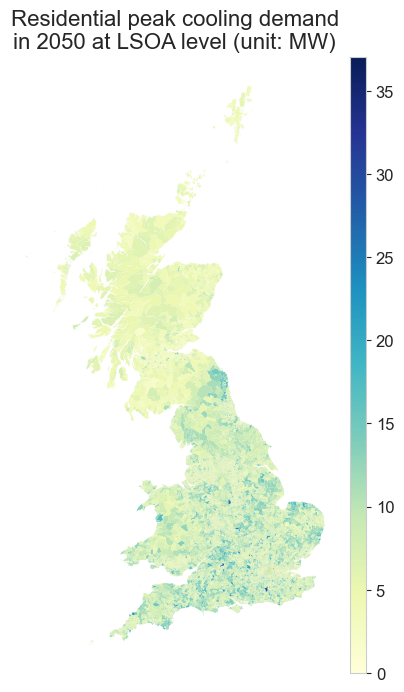

In [54]:
lsoa_peak
fig, ax = plt.subplots(figsize=(figsize_map))
cmap_1 = "YlGnBu"
target = 'Peak cooling demand (MW)'
map_obj = viz_functions.plot_map(map_df,
                                 target,
                                 ax,
                                 vmin=0,
                                 cmap=cmap_1,
                                 legend=True)

ax.set_title(
    f"Residential peak cooling demand\nin 2050 at LSOA level (unit: MW)")
fig.savefig(PATH_SAVE_FIGURES/f"residential_peak_cooling_demand_lsoa_map.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"residential_peak_cooling_demand_lsoa_map.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

fig

In [55]:
map_df = viz_functions.get_UK_LSOA_map()
summary_lsoa_cooling_demand = (lsoa_cooling_demand.sum()/1_000_000).to_frame()
summary_lsoa_cooling_demand.columns = ['Cooling demand (GWh)']
map_df = pd.merge(map_df,
                  summary_lsoa_cooling_demand,
                  left_on='LSOA11CD',
                  right_index=True)
summary_lsoa_cooling_demand.describe()

,Cooling demand (GWh)
count,41726.000000
mean,0.916323
std,0.491758
min,0.035422
25%,0.564026
50%,0.892908
75%,1.197773
max,8.983260


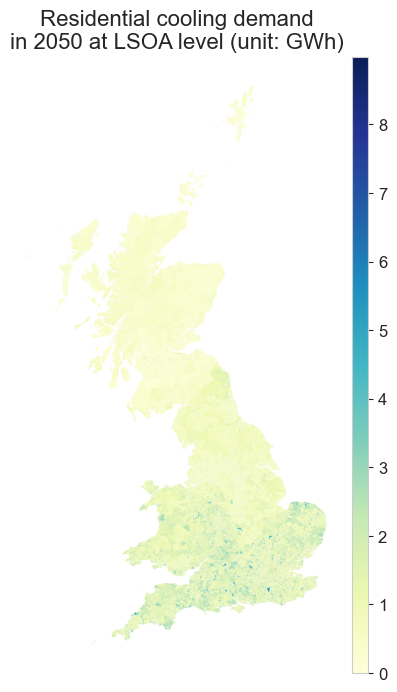

In [56]:
fig, ax = plt.subplots(figsize=(figsize_map))
cmap_1 = "YlGnBu"
target = f'Cooling demand (GWh)'
map_obj = viz_functions.plot_map(map_df,
                                 target,
                                 ax,
                                 vmin=0,
                                 cmap=cmap_1,
                                 legend=True)

ax.set_title(f"Residential cooling demand\nin 2050 at LSOA level (unit: GWh)")
fig.savefig(PATH_SAVE_FIGURES/f"residential_cooling_demand_lsoa_map.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"residential_cooling_demand_lsoa_map.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

fig